In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn import tree


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import acquire as a
import prepare as p
import explore as e

# Decision Tree - Exercises

In [2]:
# Acquire the data

df = a.get_titanic_data()
df.tail()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
886,886,0,2,male,27.0,0,0,13.00,S,Second,NaN,Southampton,1
887,887,1,1,female,19.0,0,0,30.00,S,First,B,Southampton,1
888,888,0,3,female,NaN,1,2,23.45,S,Third,NaN,Southampton,0
889,889,1,1,male,26.0,0,0,30.00,C,First,C,Cherbourg,1
890,890,0,3,male,32.0,0,0,7.75,Q,Third,NaN,Queenstown,1


In [3]:
# check for empty column values
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

- 'age' is missing almost 20% of its values
- 'deck' is missing more than 75% of values, can be dropped
- 'embark_town' and 'embarked' show identical data, only missing 2 values
- 'passenger_id' can be reassigned as the index since all values are sequential and unique
- 'class' and 'pclass' have identical data

In [4]:
df.embark_town.value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [5]:
# Prep the data

# drop any duplicate rows
df = df.drop_duplicates()

# change index to passenger_id
df = df.set_index("passenger_id")

#drop any repetitive or unusable columns
df = df.drop(columns=['deck', 'embarked', 'class'])

# fill two missing values with most common value
df['embark_town'] = df.embark_town.fillna(value='Southampton')

# create encoded columns to replace categorical features and concat features to dataframe
# resulting features are:
    #is_male for 'sex' 
    #'embark_town_Queenstown' and 'embark_town_Southampton' for 'embark_town'
dummy_df = pd.get_dummies(df[['sex', 'embark_town']], drop_first=True)
df = pd.concat([df, dummy_df], axis=1)

# fill missing 'age' values
df['age'] = df.age.fillna(value=df.age.median())

In [6]:
df.isna().sum()

survived                   0
pclass                     0
sex                        0
age                        0
sibsp                      0
parch                      0
fare                       0
embark_town                0
alone                      0
sex_male                   0
embark_town_Queenstown     0
embark_town_Southampton    0
dtype: int64

Next we split the data for training, validation, and testing:

In [7]:
train, validate, test = p.split_data(df)

print(train.shape, validate.shape, test.shape)
train.sample(5)

(498, 12) (214, 12) (179, 12)


,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,,,
85,1,3,female,33.0,3,0,15.8500,Southampton,0,0,0,1
358,1,3,female,28.0,0,0,7.8792,Queenstown,1,0,1,0
246,0,3,female,25.0,0,0,7.7750,Southampton,1,0,0,1
309,1,1,female,30.0,0,0,56.9292,Cherbourg,1,0,0,0
539,1,1,female,22.0,0,2,49.5000,Cherbourg,0,0,0,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 498 non-null    int64  
 1   pclass                   498 non-null    int64  
 2   sex                      498 non-null    object 
 3   age                      498 non-null    float64
 4   sibsp                    498 non-null    int64  
 5   parch                    498 non-null    int64  
 6   fare                     498 non-null    float64
 7   embark_town              498 non-null    object 
 8   alone                    498 non-null    int64  
 9   sex_male                 498 non-null    uint8  
 10  embark_town_Queenstown   498 non-null    uint8  
 11  embark_town_Southampton  498 non-null    uint8  
dtypes: float64(2), int64(5), object(2), uint8(3)
memory usage: 40.4+ KB


In [9]:
# Split new sample variables into X and y
# y_*: Series, target variable
# X_*: Dataframe, features
X_train, y_train = train.drop(columns=['sex','survived','embark_town']), train.survived

X_validate, y_validate = validate.drop(columns=['sex','survived','embark_town']), validate.survived

X_test, y_test = test.drop(columns=['sex','survived','embark_town']), test.survived

### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [10]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

Since most passengers did not survive ('0'), our baseline prediction will be 'survive == 0'

In [11]:
# 1. Create the baseline
baseline = DummyClassifier(strategy='constant', constant=0) # baseline predicts no survivors

# 2. Fit the baseline
baseline.fit(X_train, y_train)

DummyClassifier(constant=0, strategy='constant')

In [12]:
accuracy = round(baseline.score(X_train, y_train), 4)
print(f'Baseline prediction accuracy: {round(100*accuracy, 4)}%')

Baseline prediction accuracy: 61.65%


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [13]:
# 1. Create tje object

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [14]:
# Fit the model

clf = clf.fit(X_train, y_train)

In [15]:
# Visualize
import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=False)

'titanic_decision_tree.pdf'

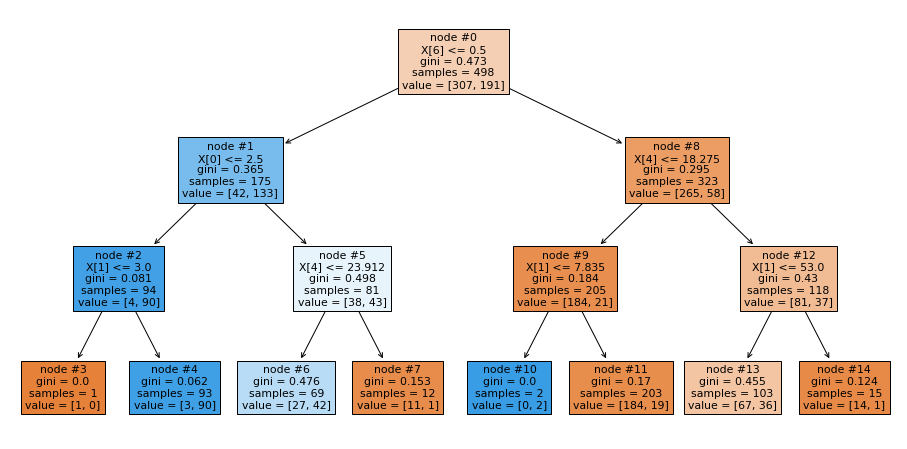

In [16]:
plt.figure(figsize=(16, 8))
titanic_decision_tree = tree.plot_tree(clf, node_ids=True, filled=True, impurity=True)

In [17]:
# Make predictions on in_sample data

y_pred = clf.predict(X_train)
y_pred[0:25]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0])

In [18]:
# Estimate probability of passengers surviving (left column: died, right column: survived)

y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.65048544, 0.34951456],
       [0.65048544, 0.34951456],
       [0.65048544, 0.34951456],
       [0.03225806, 0.96774194],
       [0.03225806, 0.96774194]])

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [19]:
# percentage of correct predictions over evaluated data
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.83


#### Confusion Matrix

In [20]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat = confusion_matrix(y_train, y_pred)
con_mat

array([[277,  30],
       [ 57, 134]])

Positive case: Survived

Negative case: Died

In [21]:
# True positive = Survived and marked as survived
tp = con_mat[1][1]

# True negative = Died and marked as died
tn = con_mat[0][0]

# False positive = Died but marked as survived
fp = con_mat[1][0]

# False negative = Survived but marked as died
fn = con_mat[0][1]

**Classification Report**

In [22]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.829341,0.817073,0.825301,0.823207,0.824636
recall,0.902280,0.701571,0.825301,0.801925,0.825301
f1-score,0.864275,0.754930,0.825301,0.809602,0.822337
support,307.000000,191.000000,0.825301,498.000000,498.000000


### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [23]:
a = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', round(a, 4))

p = tp/(tp+fp)
print('Precision:', round(p, 4))

r = tp/(tp+fn)
print('Recall:   ', round(r, 4))

f_1 = 2*r*p/(r+p)
print('F-1 Score:', round(f_1, 4))

Accuracy:  0.8253
Precision: 0.7016
Recall:    0.8171
F-1 Score: 0.7549


In [24]:
tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.8171
 True negative rate = 0.8293
False positive rate = 0.1707
False negative rate = 0.1829


In [25]:
survived_sup = y_train[y_train==1].count()
print('Survived support:',survived_sup)
died_sup = y_train[y_train==0].count()
print('    Died support:',died_sup)

Survived support: 191
    Died support: 307


In [26]:
# test accuracy on validate dataset
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.80


In [27]:
# y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.811189,0.774648,0.799065,0.792918,0.797187
recall,0.878788,0.670732,0.799065,0.774760,0.799065
f1-score,0.843636,0.718954,0.799065,0.781295,0.795861
support,132.000000,82.000000,0.799065,214.000000,214.000000


### 5. Run through steps 2-4 using a different max_depth value.

In [28]:
print('         Model Accuracy vs. Max Depth')
print()
for i in range(1,8):
    clf = DecisionTreeClassifier(max_depth=i, random_state=1234)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)
    print('---------------')
    print(f'Max depth {i} on: - training set:', clf.score(X_train, y_train))
    print('                - validate set:', clf.score(X_validate, y_validate))

         Model Accuracy vs. Max Depth

---------------
Max depth 1 on: - training set: 0.7991967871485943
                - validate set: 0.7616822429906542
---------------
Max depth 2 on: - training set: 0.7991967871485943
                - validate set: 0.7616822429906542
---------------
Max depth 3 on: - training set: 0.8253012048192772
                - validate set: 0.7990654205607477
---------------
Max depth 4 on: - training set: 0.8353413654618473
                - validate set: 0.794392523364486
---------------
Max depth 5 on: - training set: 0.8534136546184738
                - validate set: 0.8037383177570093
---------------
Max depth 6 on: - training set: 0.8654618473895582
                - validate set: 0.7897196261682243
---------------
Max depth 7 on: - training set: 0.8835341365461847
                - validate set: 0.7850467289719626


### 6, 7. Which model performs better on your in-sample data? Out-of-sample data (the validate set)?

The model that performs best on the in-sample data is the model that has largest max depth of 6.

The model that performs best on the out-of-sample data is the model with a max depth of 5.

By looking at the change in max depth vs the change in accuracies, it becomes clear that, although the in-sample accuracy increases with max depth, the out-of-sample accuracy decreases past a max depth of 5. This hints to the fact that the higher accuracy in the model with max_depth=6 is a result of over-fitting, and that it may be best to stay under that number.

# Random Forests - Exercises

In [29]:
from sklearn.ensemble import RandomForestClassifier

### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

First we will create the model using the X_train and y_train data:

In [30]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

Fit the model to the random forest classifier:

In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [32]:
print(X_train.columns)
print(rf.feature_importances_)

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male',
       'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')
[0.08948574 0.2187192  0.05511936 0.02846755 0.23923619 0.01805384
 0.31226911 0.01487009 0.02377892]


From feature_importances_, we see that age, fare, and sex are all important feartures.

In [33]:
# make predictions
y_pred = rf.predict(X_train)
y_pred[0:5]

array([0, 1, 0, 1, 1])

In [34]:
# predicted probability of survival rate
# left column = died, right = survived
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.74364871, 0.25635129],
       [0.23583333, 0.76416667],
       [0.976     , 0.024     ],
       [0.03333333, 0.96666667],
       [0.01      , 0.99      ]])

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [35]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on training set: 0.97
Accuracy of random forest classifier on test set: 0.81


In [36]:
con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred), index=['act_died','act_surv'], columns=['pred_died','pred_surv'])
con_mat

,pred_died,pred_surv
act_died,307,0
act_surv,15,176


In [37]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.953416,1.000000,0.96988,0.976708,0.971283
recall,1.000000,0.921466,0.96988,0.960733,0.969880
f1-score,0.976153,0.959128,0.96988,0.967640,0.969623
support,307.000000,191.000000,0.96988,498.000000,498.000000


### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

Positive case: Survived

Negative case: Died

In [38]:
# True positive = Survived and marked as survived
tp = con_mat.pred_surv[1]

# True negative = Died and marked as died
tn = con_mat.pred_died[0]

# False positive = Died but marked as survived
fp = con_mat.pred_surv[0]

# False negative = Survived but marked as died
fn = con_mat.pred_died[1]

In [39]:
a = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', round(a, 4))
p = tp/(tp+fp)
print('Precision:', round(p, 4))
r = tp/(tp+fn)
print('Recall:   ', round(r, 4))
f_1 = 2*r*p/(r+p)
print('F-1 Score:', round(f_1, 4))

Accuracy:  0.9699
Precision: 1.0
Recall:    0.9215
F-1 Score: 0.9591


In [40]:
tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))
tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))
fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))
fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.9215
 True negative rate = 1.0
False positive rate = 0.0
False negative rate = 0.0785


In [41]:
survived_sup = y_train[y_train==1].count()
print('Survived support:',survived_sup)
died_sup = y_train[y_train==0].count()
print('    Died support:',died_sup)

Survived support: 191
    Died support: 307


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [42]:
rf1 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=9, 
                            random_state=123)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf1.score(X_train, y_train)))
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

Accuracy of random forest classifier on training set: 0.90


,0,1,accuracy,macro avg,weighted avg
precision,0.883929,0.938272,0.901606,0.911100,0.904771
recall,0.967427,0.795812,0.901606,0.881619,0.901606
f1-score,0.923795,0.861190,0.901606,0.892492,0.899784
support,307.000000,191.000000,0.901606,498.000000,498.000000


In [43]:
rf2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=123)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf2.score(X_train, y_train)))
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

Accuracy of random forest classifier on training set: 0.88


,0,1,accuracy,macro avg,weighted avg
precision,0.864706,0.917722,0.881526,0.891214,0.885039
recall,0.957655,0.759162,0.881526,0.858409,0.881526
f1-score,0.908810,0.830946,0.881526,0.869878,0.878946
support,307.000000,191.000000,0.881526,498.000000,498.000000


In [44]:
rf3 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=7,
                            n_estimators=100,
                            max_depth=7, 
                            random_state=123)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf3.score(X_train, y_train)))
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

Accuracy of random forest classifier on training set: 0.86


,0,1,accuracy,macro avg,weighted avg
precision,0.842407,0.912752,0.863454,0.877579,0.869387
recall,0.957655,0.712042,0.863454,0.834848,0.863454
f1-score,0.896341,0.800000,0.863454,0.848171,0.859391
support,307.000000,191.000000,0.863454,498.000000,498.000000


In [45]:
rf4 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=9,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=123)
rf4.fit(X_train, y_train)
y_pred = rf4.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf4.score(X_train, y_train)))
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

Accuracy of random forest classifier on training set: 0.86


,0,1,accuracy,macro avg,weighted avg
precision,0.836676,0.899329,0.855422,0.868003,0.860706
recall,0.951140,0.701571,0.855422,0.826355,0.855422
f1-score,0.890244,0.788235,0.855422,0.839240,0.851120
support,307.000000,191.000000,0.855422,498.000000,498.000000


In [46]:
rf5 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=11,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)
rf5.fit(X_train, y_train)
y_pred = rf5.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf5.score(X_train, y_train)))
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

Accuracy of random forest classifier on training set: 0.84


,0,1,accuracy,macro avg,weighted avg
precision,0.828080,0.879195,0.843373,0.853637,0.847684
recall,0.941368,0.685864,0.843373,0.813616,0.843373
f1-score,0.881098,0.770588,0.843373,0.825843,0.838713
support,307.000000,191.000000,0.843373,498.000000,498.000000


### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

- The first model made had the highest accuracy of all with ~97%
- The first model also had the highest F-1 score of all models with ~96%
- Regarding the performance on in-smaple data, the first model has the best scores because it is slightly over-fitted for the in-sample data

### After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [47]:
print(f'Model 0 on: - training set:', rf.score(X_train, y_train))
print('            - validate set:', rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 1 on: - training set:', rf1.score(X_train, y_train))
print('            - validate set:', rf1.score(X_validate, y_validate))
print('--------------')
print(f'Model 2 on: - training set:', rf2.score(X_train, y_train))
print('            - validate set:', rf2.score(X_validate, y_validate))
print('--------------')
print(f'Model 3 on: - training set:', rf3.score(X_train, y_train))
print('            - validate set:', rf3.score(X_validate, y_validate))
print('--------------')
print(f'Model 4 on: - training set:', rf4.score(X_train, y_train))
print('            - validate set:', rf4.score(X_validate, y_validate))
print('--------------')
print(f'Model 5 on: - training set:', rf5.score(X_train, y_train))
print('            - validate set:', rf5.score(X_validate, y_validate))

Model 0 on: - training set: 0.9698795180722891
            - validate set: 0.8130841121495327
--------------
Model 1 on: - training set: 0.9016064257028112
            - validate set: 0.822429906542056
--------------
Model 2 on: - training set: 0.8815261044176707
            - validate set: 0.7897196261682243
--------------
Model 3 on: - training set: 0.8634538152610441
            - validate set: 0.7897196261682243
--------------
Model 4 on: - training set: 0.8554216867469879
            - validate set: 0.794392523364486
--------------
Model 5 on: - training set: 0.8433734939759037
            - validate set: 0.780373831775701


In [48]:
print(f'Model 0', rf.score(X_train, y_train)-rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 1', rf1.score(X_train, y_train)-rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 2', rf2.score(X_train, y_train)-rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 3', rf3.score(X_train, y_train)-rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 4', rf4.score(X_train, y_train)-rf.score(X_validate, y_validate))
print('--------------')
print(f'Model 5', rf5.score(X_train, y_train)-rf.score(X_validate, y_validate))

Model 0 0.15679540592275643
--------------
Model 1 0.08852231355327855
--------------
Model 2 0.06844199226813796
--------------
Model 3 0.050369703111511455
--------------
Model 4 0.04233757459745524
--------------
Model 5 0.030289381826370976


Model 5 has the closest perfomance on both in-sample and out-of-sample datasets with a max_depth=5 and min_samples_leaf=11.

# K-Nearest Neighbor - Exercises

In [49]:
from sklearn.neighbors import KNeighborsClassifier

### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

1. Create the object

In [50]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

2. Fit the model

In [51]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

3. Make predictions

In [52]:
y_pred = knn.predict(X_train)
y_pred[:5]

array([0, 1, 0, 1, 1])

5. Estimate probabilities

In [53]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba[:5]

array([[0.6, 0.4],
       [0.2, 0.8],
       [0.8, 0.2],
       [0.4, 0.6],
       [0.2, 0.8]])

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [54]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.79


In [55]:
con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred))
con_mat

,0,1
0,256,51
1,52,139


In [56]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.831169,0.731579,0.793173,0.781374,0.792973
recall,0.833876,0.727749,0.793173,0.780812,0.793173
f1-score,0.832520,0.729659,0.793173,0.781090,0.793069
support,307.000000,191.000000,0.793173,498.000000,498.000000


### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

Positive case: Survived

Negative case: Died

In [57]:
# True positive = Survived and marked as survived
tp = con_mat[1][1]

# True negative = Died and marked as died
tn = con_mat[0][0]

# False positive = Died but marked as survived
fp = con_mat[1][0]

# False negative = Survived but marked as died
fn = con_mat[1][0]

In [58]:
a = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', round(a, 4))
p = tp/(tp+fp)
print('Precision:', round(p, 4))
r = tp/(tp+fn)
print('Recall:   ', round(r, 4))
f_1 = 2*r*p/(r+p)
print('F-1 Score:', round(f_1, 4))

Accuracy:  0.7948
Precision: 0.7316
Recall:    0.7316
F-1 Score: 0.7316


In [59]:
tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))
tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))
fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))
fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.7316
 True negative rate = 0.8339
False positive rate = 0.1661
False negative rate = 0.2684


In [60]:
survived_sup = y_train[y_train==1].count()
print('Survived support:',survived_sup)
died_sup = y_train[y_train==0].count()
print('    Died support:',died_sup)

Survived support: 191
    Died support: 307


In [61]:
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on validate set: 0.71


### 4. Run through steps 2-4 setting k to 10

In [62]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set: 0.75
Accuracy of KNN classifier on validate set: 0.71


In [63]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.743935,0.755906,0.746988,0.749920,0.748526
recall,0.899023,0.502618,0.746988,0.700820,0.746988
f1-score,0.814159,0.603774,0.746988,0.708966,0.733469
support,307.000000,191.000000,0.746988,498.000000,498.000000


In [64]:
con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred))

tp = con_mat[1][1]
tn = con_mat[0][0]
fp = con_mat[1][0]
fn = con_mat[1][0]

In [65]:
a = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', round(a, 4))
p = tp/(tp+fp)
print('Precision:', round(p, 4))
r = tp/(tp+fn)
print('Recall:   ', round(r, 4))
f_1 = 2*r*p/(r+p)
print('F-1 Score:', round(f_1, 4))

Accuracy:  0.8571
Precision: 0.7559
Recall:    0.7559
F-1 Score: 0.7559


In [66]:
tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))
tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))
fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))
fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.7559
 True negative rate = 0.899
False positive rate = 0.101
False negative rate = 0.2441


### 5. Run through setps 2-4 setting k to 20

In [67]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set: 0.72
Accuracy of KNN classifier on validate set: 0.72


In [68]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.723118,0.698413,0.716867,0.710765,0.713643
recall,0.876221,0.460733,0.716867,0.668477,0.716867
f1-score,0.792342,0.555205,0.716867,0.673773,0.701392
support,307.000000,191.000000,0.716867,498.000000,498.000000


In [69]:
con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred))

tp = con_mat[1][1]
tn = con_mat[0][0]
fp = con_mat[1][0]
fn = con_mat[1][0]

In [70]:
a = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', round(a, 4))
p = tp/(tp+fp)
print('Precision:', round(p, 4))
r = tp/(tp+fn)
print('Recall:   ', round(r, 4))
f_1 = 2*r*p/(r+p)
print('F-1 Score:', round(f_1, 4))

Accuracy:  0.8245
Precision: 0.6984
Recall:    0.6984
F-1 Score: 0.6984


In [71]:
tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))
tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))
fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))
fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.6984
 True negative rate = 0.8762
False positive rate = 0.1238
False negative rate = 0.3016


### 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

For k = 5
Accuracy:  0.7948
Precision: 0.7316
Recall:    0.7316
F-1 Score: 0.7316
----------
For k = 10
Accuracy:  0.8571
Precision: 0.7559
Recall:    0.7559
F-1 Score: 0.7559
----------
For k = 15
Accuracy:  0.8288
Precision: 0.7226
Recall:    0.7226
F-1 Score: 0.7226
----------
For k = 20
Accuracy:  0.8245
Precision: 0.6984
Recall:    0.6984
F-1 Score: 0.6984
----------
For k = 25
Accuracy:  0.7783
Precision: 0.6528
Recall:    0.6528
F-1 Score: 0.6528
----------


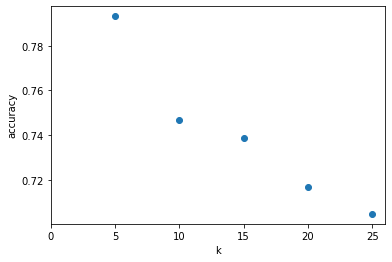

In [72]:
scores=[]
k_range = [5,10,15,20,25]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    training_acc = knn.score(X_train, y_train)
    
    #confusion matrix
    con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred))
    tp = con_mat[1][1]
    tn = con_mat[0][0]
    fp = con_mat[1][0]
    fn = con_mat[1][0]
    print('For k =', k)
    #eval metrics
    a = (tp+tn)/(tp+tn+fp+fn)
    print('Accuracy: ', round(a, 4))
    p = tp/(tp+fp)
    print('Precision:', round(p, 4))
    r = tp/(tp+fn)
    print('Recall:   ', round(r, 4))
    f_1 = 2*r*p/(r+p)
    print('F-1 Score:', round(f_1, 4))
    print('----------')
    scores.append(knn.score(X_train, y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20,25])
plt.show()

Based on the metrics and the graph, the model with k=5 performed the best on in-sample data.

### 7. Which model performs best on our out-of-sample data from validate?

    k  train_accuracy  validate_accuracy
0   1        0.993976           0.705607
1   5        0.793173           0.705607
2  10        0.746988           0.710280
3  15        0.738956           0.738318
4  20        0.716867           0.719626
5  25        0.704819           0.705607


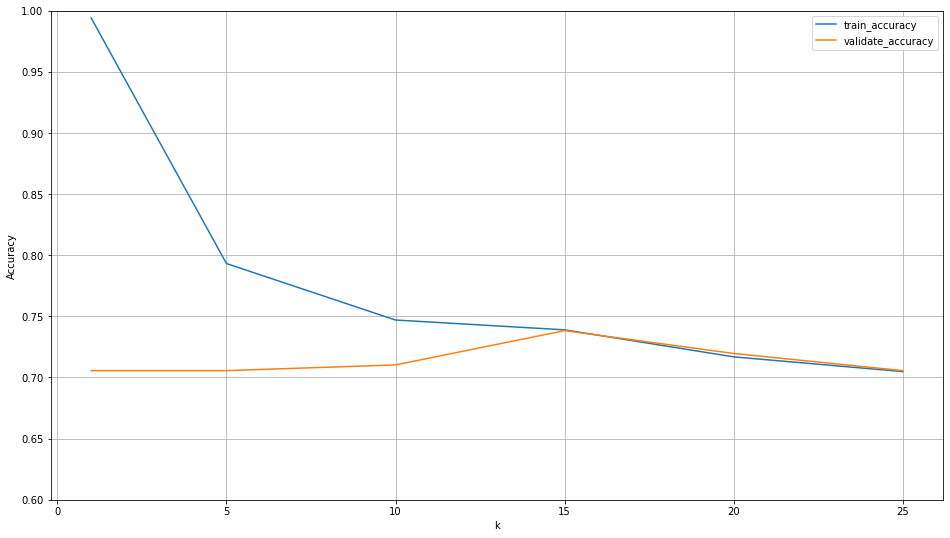

In [73]:
k_val = [1,5,10,15,20,25]
metrics = []

# loop through different values of k
for k in k_val:
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)
print(results)

# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylim(0.60, 1)
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,30,5))
plt.grid()

For out-of-sample data, the model with k=15 performed the best and also preformed just as well on the in-sample data.

Of the model with k=5, 10, and 20, model 20 performed the best.

Feature: 0, Score: 0.00884
Feature: 1, Score: 0.14337
Feature: 2, Score: 0.00321
Feature: 3, Score: 0.00241
Feature: 4, Score: 0.21205
Feature: 5, Score: 0.00361
Feature: 6, Score: 0.03815
Feature: 7, Score: -0.00201
Feature: 8, Score: -0.00522


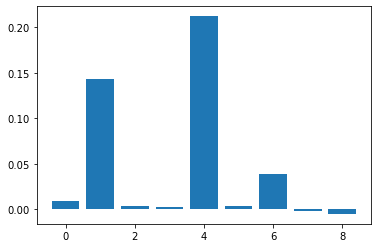

In [74]:
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train, y_train)
# perform permutation importance
results = permutation_importance(model, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [75]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male',
       'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')

# Logistic Regression - Exercises

In [76]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pydataset import data

import acquire as a
import prepare as p
import explore as e

Acquire, Prepare, and Clean

In [77]:
df = a.get_titanic_data()
df = df.drop_duplicates()
df = df.set_index("passenger_id")
df = df.drop(columns=['deck', 'embarked', 'class'])
df['embark_town'] = df.embark_town.fillna(value='Southampton')
dummy_df = pd.get_dummies(df[['sex', 'embark_town']], drop_first=True)
df = pd.concat([df, dummy_df], axis=1)
df['age'] = df.age.fillna(value=df.age.median())

In [78]:
train, validate, test = p.split_data(df)

print(train.shape, validate.shape, test.shape)
train.sample(5)

(498, 12) (214, 12) (179, 12)


,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,,,
818,0,3,male,43.0,0,0,6.4500,Southampton,1,1,0,1
574,0,3,male,16.0,0,0,8.0500,Southampton,1,1,0,1
774,1,2,female,54.0,1,3,23.0000,Southampton,0,0,0,1
810,0,3,male,26.0,0,0,7.8875,Southampton,1,1,0,1
164,0,3,male,1.0,4,1,39.6875,Southampton,0,1,0,1


In [79]:
# Split new sample variables into X and y
# y_*: Series, target variable
# X_*: Dataframe, features
X_train, y_train = train.drop(columns=['sex','survived','embark_town']), train.survived

X_validate, y_validate = validate.drop(columns=['sex','survived','embark_town']), validate.survived

X_test, y_test = test.drop(columns=['sex','survived','embark_town']), test.survived
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pclass                   498 non-null    int64  
 1   age                      498 non-null    float64
 2   sibsp                    498 non-null    int64  
 3   parch                    498 non-null    int64  
 4   fare                     498 non-null    float64
 5   alone                    498 non-null    int64  
 6   sex_male                 498 non-null    uint8  
 7   embark_town_Queenstown   498 non-null    uint8  
 8   embark_town_Southampton  498 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 28.7 KB


**1. Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?**

In [119]:
X_train1 = X_train.drop(columns=['sex_male','embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])

X_validate1 = X_validate.drop(columns=['sex_male','embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])

X_test1 = X_test.drop(columns=['sex_male','embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])
X_train1.head()

,pclass,age,fare
passenger_id,,,
583,1,36.0,40.1250
165,3,9.0,20.5250
50,3,7.0,39.6875
259,2,50.0,26.0000
306,1,28.0,110.8833


Baseline model:

In [120]:
baseline = DummyClassifier(strategy='constant', constant=0) # Most common outcome as prediction

baseline.fit(X_train, y_train)

accuracy = round(baseline.score(X_train, y_train), 4)
print(f'Baseline prediction accuracy: {round(100*accuracy, 4)}%')

Baseline prediction accuracy: 61.65%


Model 1:

In [128]:
X_train1.isnull().sum()

pclass    0
age       0
fare      0
dtype: int64

In [132]:
# Create the model

logit = LogisticRegression(C=1, random_state=123)

In [136]:
# Fit the model

logit.fit(X_train1, y_train)

LogisticRegression(C=1, random_state=123)

In [137]:
# Find feature importance

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.9526243  -0.0304467   0.00141806]]
Intercept: 
 [2.52032223]


In [138]:
# Make predictions

y_pred = logit.predict(X_train1)
y_pred[:5]

array([1, 0, 0, 0, 1])

In [139]:
# Give probability of survival

y_pred_proba = logit.predict_proba(X_train1)
y_pred_proba[:5]

array([[0.370863  , 0.629137  ],
       [0.64163447, 0.35836553],
       [0.62114201, 0.37885799],
       [0.70482725, 0.29517275],
       [0.29474901, 0.70525099]])

In [140]:
# Evaluate the model

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train1, y_train)))
print()
print('---------')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred))
print()
print('---------')
print()
print('Classification Report:')
print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.70

---------

Confusion Matrix:
[[267  40]
 [108  83]]

---------

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       307
           1       0.67      0.43      0.53       191

    accuracy                           0.70       498
   macro avg       0.69      0.65      0.66       498
weighted avg       0.70      0.70      0.69       498



Compared to the baseline model's accuracy (61.65%), the logistic regression model did well (70%) without gender available as a feature.

**2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.**

In [145]:
X_train2 = X_train.drop(columns=['embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])

X_validate2 = X_validate.drop(columns=['embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])

X_test2 = X_test.drop(columns=['embark_town_Queenstown','embark_town_Southampton','parch','sibsp','alone'])
X_train1.head()

,pclass,age,fare
passenger_id,,,
583,1,36.0,40.1250
165,3,9.0,20.5250
50,3,7.0,39.6875
259,2,50.0,26.0000
306,1,28.0,110.8833


Model 2:

In [146]:
logit1 = LogisticRegression(C=1, random_state=123)
logit1.fit(X_train2, y_train)

LogisticRegression(C=1, random_state=123)

In [147]:
print('Coefficient: \n', logit1.coef_)
print('Intercept: \n', logit1.intercept_)

Coefficient: 
 [[-1.21154022e+00 -2.93615278e-02 -2.00493198e-03 -2.71427548e+00]]
Intercept: 
 [4.82137425]


In [182]:
y_pred = logit1.predict(X_train2)
y_pred_proba = logit1.predict_proba(X_train2)

In [183]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train2, y_train)))
print()
print('---------')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred))
print()
print('---------')
print()
print('Classification Report:')
print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.81

---------

Confusion Matrix:
[[262  45]
 [ 51 140]]

---------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       307
           1       0.76      0.73      0.74       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.79       498
weighted avg       0.81      0.81      0.81       498



By including sex as a feature, the model's in-sample accuracy increased to 81%.

**3. Try out other combinations of features and models.**

In [184]:
from sklearn.model_selection import GridSearchCV

In [185]:
logit = LogisticRegression()

In [186]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
    }
]

In [187]:
clf = GridSearchCV(logit, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [188]:
best_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


In [189]:
best_clf.best_estimator_

LogisticRegression(C=0.08858667904100823, solver='newton-cg')

In [190]:
logit = LogisticRegression(C=0.08858667904100823, solver='newton-cg')

In [191]:
logit.fit(X_train, y_train)
logit.score(X_train, y_train)

0.8293172690763052

In [193]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

In [196]:
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on validate set: 0.79
Accuracy of Logistic Regression classifier on validate set: 0.79
Accuracy of Logistic Regression classifier on validate set: 0.80


**4.Use you best 3 models to predict and evaluate on your validate sample.**

**5. Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?**

**Bonus1 How do different strategies for handling the missing values in the age column affect**

**Bonus2: How do different strategies for encoding sex affect model performance?**

**Bonus3: scikit-learn's LogisticRegression classifier is actually applying a regularization penalty to the coefficients by default. This penalty causes the magnitude of the coefficients in the resulting model to be smaller than they otherwise would be. This value can be modified with the C hyper parameter. Small values of C correspond to a larger penalty, and large values of C correspond to a smaller penalty**

**Try out the following values for C and note how the coefficients and the model's performance on both the dataset it was trained on and on the validate split are affected.**

                                        C = .01, .1, 1, 10 , 100, 1000

**Bonus Bonus: how does scaling the data interact with your choice of C?**